# Floquet Formalism

Author: C. Staufenbiel, 2022

inspirations taken from the [Floquet notebook](https://github.com/qutip/qutip-notebooks/blob/master/examples/floquet-dynamics.ipynb) by P.D. Nation and J.R. Johannson,

and the [qutip documentation](https://qutip.org/docs/latest/guide/dynamics/dynamics-floquet.html).

### Introduction
In the [floquet_solver notebook](011_floquet_solver.md) we introduced the two functions to solve the Schrödinger and Master equation using the Floquet formalism. In this notebook, we will focus on the internal functions of these solvers, that implement the Floquet formalism in QuTiP. Here, we will focus on the `Floquet modes` and the `quasienergies`.

More information on the implementation of the Floquet Formalism in QuTiP can be found in the [documentation](https://qutip.org/docs/latest/guide/dynamics/dynamics-floquet.html).

### Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, expect, floquet_markov_mesolve,
                   floquet_master_equation_rates,
                   floquet_master_equation_tensor, floquet_modes,
                   floquet_modes_t, floquet_modes_t_lookup,
                   floquet_modes_table, floquet_state_decomposition,
                   floquet_wavefunction, floquet_wavefunction_t, fmmesolve,
                   ket2dm, num, plot_wigner, rand_ket, sesolve, sigmax, sigmaz)

### System setup
For consistency with the documentation we consider the driven system with the following Hamiltonian: 

$$ H = - \frac{\Delta}{2} \sigma_x - \frac{\epsilon_0}{2} \sigma_z + \frac{A}{2} \sigma_x sin(\omega t) $$

In [2]:
# Constants
delta = 0.2 * 2 * np.pi
eps0 = 1 * 2 * np.pi
A = 2.5 * 2 * np.pi
omega = 1.0 * 2 * np.pi
T = 2 * np.pi / omega

# Hamiltonian
H = [
    -delta / 2.0 * sigmax() - eps0 / 2.0 * sigmaz(),
    [A / 2 * sigmax(), "sin({w}*t)".format(w=omega)],
]

### Floquet modes and quasienergies
For periodic Hamiltonians the solution to the Schrödinger equation can be represented by the Floquet modes $\phi_\alpha(t)$ and the quasienergies $\epsilon_\alpha$. We can obtain these for the initial time $t=0$ by using the function `floquet_modes()`. We can display for example the first Floquet mode at $t=0$ using a Wigner distribution.

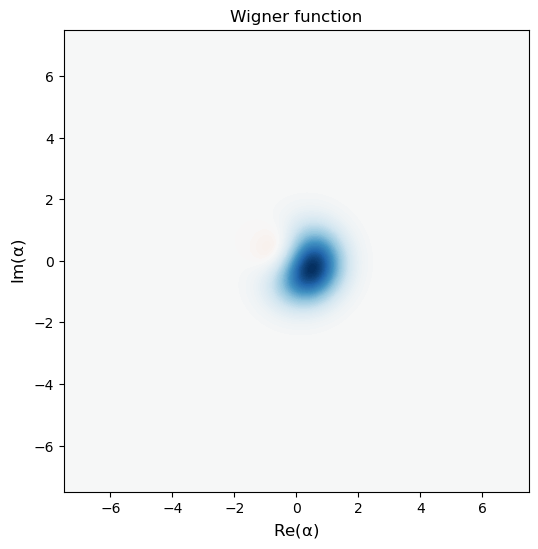

In [3]:
f_modes0, f_energies = floquet_modes(H, T)
plot_wigner(f_modes0[0]);

For the system defined above there are two eigenenergies. For the defined system, we can plot the two quasienergies for varying strength of driving $A$.

In [4]:
A_list = np.linspace(1.0 * omega, 4.5 * omega, 20)
quasienergies1, quasienergies2 = [], []
for A_tmp in A_list:
    # temporary Hamiltonian
    H_tmp = [
        -delta / 2.0 * sigmax() - eps0 / 2.0 * sigmaz(),
        [A_tmp / 2 * sigmax(), "sin({w}*t)".format(w=omega)],
    ]
    # floquet modes and quasienergies
    _, (e1, e2) = floquet_modes(H_tmp, T, sort=True)
    quasienergies1.append(e1), quasienergies2.append(e2)

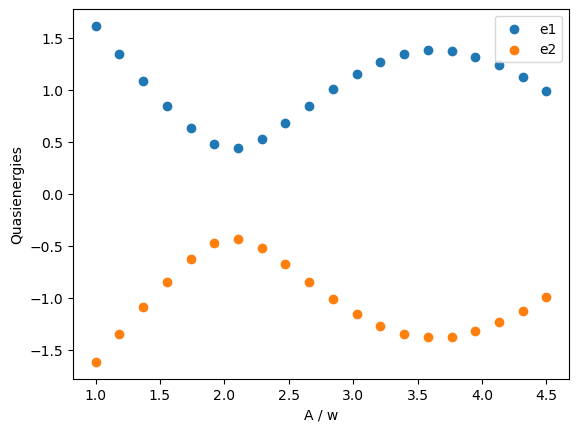

In [5]:
plt.scatter(A_list / omega, quasienergies1, label="e1")
plt.scatter(A_list / omega, quasienergies2, label="e2")
plt.xlabel("A / w"), plt.ylabel("Quasienergies")
plt.legend();

### Time evolution with Floquet mode
To calculate the time evolution of a random initial state $\psi(0)$, we have to decompose the state in the Floquet basis (formed by the Floquet modes).

$$ \psi(0) = \sum_\alpha c_\alpha \phi_\alpha(0) $$

The $c_\alpha$ are calculated by `floquet_state_decomposition`.

In [6]:
# Decompose initial state
psi0 = rand_ket(2)
f_coeff = floquet_state_decomposition(f_modes0, f_energies, psi0)

The Floquet mode $\phi_\alpha(t)$ for later times $t>0$ can be calculated using the wave function propagator $U(t,0)$ by:

$$ \phi_\alpha(t) = exp(-i\epsilon_\alpha t / \hbar) \, U(t,0) \, \phi_\alpha(0) $$

In QuTiP this is done by the `floquet_modes_t` function. Here we propagate the initial state to the state at $t=1$.

In [7]:
t = 1.0
f_modes1 = floquet_modes_t(f_modes0, f_energies, t, H, T)
f_modes1

[Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[0.89846111+0.j        ]
  [0.39260919-0.19653412j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.39260919-0.19653412j]
  [ 0.89846111+0.j        ]]]

The propagated Floquet modes $\phi_\alpha(t)$ can be combined to describe the full system state $\psi(t)$ at the time t. This combination can be done by `floquet_wavefunction`.

In [8]:
psi_t = floquet_wavefunction(f_modes1, f_energies, f_coeff, t)

Instead of propagating the Floquet modes and building them together manually, we can use the Floquet coefficients `f_coeff` from the initial state decomposition to calculate the propagated system state $\psi(t)$ by using `floquet_wavefunction_t`. This evolution is similar to the manual evolution above.

In [9]:
psi_t_direct = floquet_wavefunction_t(f_modes0, f_energies, f_coeff, t, H, T)
assert np.allclose(psi_t.full(), psi_t_direct.full())

### Precomputing and reusing the Floquet modes of one period

The Floquet modes have the same periodicity as the Hamiltonian: 

$$ \phi_\alpha(t + T) = \phi_\alpha(t) $$

Hence it is enough to evaluate the modes at times $t \in [0,T]$. From these modes we can extrapolate the system state $\psi(t)$ for any time $t$. 

The function `floquet_modes_table` allows to calculate the Floquet modes for multiple times in the first period. 


In [10]:
tlist_period = np.linspace(0, T, 50)
fmodes_table = floquet_modes_table(f_modes0, f_energies, tlist_period, H, T)

Again, the function `floquet_wavefunction` (introduced above) can be used to build the wavefunction $\psi(t)$. Here, we calculate the expectation value for the number operator in the first period.

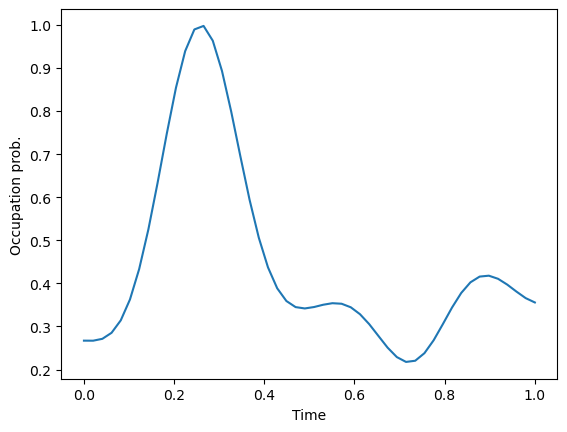

In [11]:
p_ex_period = []
for i, t in enumerate(tlist_period):
    psi_t = floquet_wavefunction(fmodes_table[i], f_energies, f_coeff, t)
    p_ex_period.append(expect(num(2), psi_t))
plt.plot(tlist_period, p_ex_period)
plt.ylabel("Occupation prob."), plt.xlabel("Time");

The pre-computed modes for the first period can be used by the function `floquet_modes_t_lookup` to calculate the Floquet modes at any time $t > 0$. Note that if a time $t'$ is not exactly $t' = t + nT$ (where $t$ is a time used in the pre-computation) the closest pre-computed Floquet mode is used. This might lead to small discontinuoties in the results from the lookup.

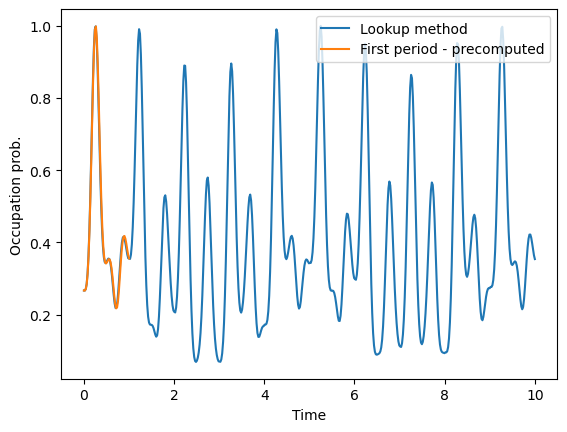

In [12]:
p_ex = []
tlist = np.linspace(0, 10 * T, 10 * tlist_period.shape[0])
for n, t in enumerate(tlist):
    f_modes_t = floquet_modes_t_lookup(fmodes_table, t, T)
    psi_t = floquet_wavefunction(f_modes_t, f_energies, f_coeff, t)
    p_ex.append(expect(num(2), psi_t))

# Plot the occupation Probability
plt.plot(tlist, p_ex, label="Lookup method")
plt.plot(tlist_period, p_ex_period, label="First period - precomputed")
plt.legend(loc="upper right")
plt.xlabel("Time"), plt.ylabel("Occupation prob.");

### Floquet Markov formalism

We can also solve a master equation using the Floquet formalism. A detailed derivation of the Floquet-Markov formalism used here is given in [Grifoni et al., Physics Reports 304, 299 (1998)](https://www.sciencedirect.com/science/article/abs/pii/S0370157398000222) and in the [QuTiP docs](https://qutip.org/docs/latest/guide/dynamics/dynamics-floquet.html). Note that the functionality described here is summarised in the function `fmmesolve` described in the [floquet solver notebook](011_floquet_solver.md).

The interaction with the bath is described by a noise spectrum, which does not include the temperature dependency. The temperature dependency can be passed to `fmmesolve` using the keyword `w_th` in the `args` parameter: `args[w_th]`. Hence, the definition is slightly different to the one in the Bloch-Redfield formalism. For details see the derivation of the formalism.

Here we define a simple linear noise spectrum: 

$$ S(\omega) = \frac{\gamma \cdot \omega}{4 \pi} $$

where $\gamma$ is the dissipation rate. We use $\sigma_x$ as a coupling operator between system and bath.

In [13]:
# Noise Spectral Density
gamma = 0.1


def noise_spectrum(omega):
    return gamma * omega / (4 * np.pi)


# Coupling Operator
c_ops = [sigmax()]

# bath temperature
temp = 10.0
args = {"w_th": temp}

The Floquet Markov approach starts by calculating rates, that describe the dissipation process of the system with the given spectrum and temperature of the bath. Especially important is `Amat`, which is later used to calculate the Floquet tensor for the master equation. 

In theory the matrix is defined as an infinite sum (see [docs](https://qutip.org/docs/latest/guide/dynamics/dynamics-floquet.html)). However, in QuTiP the sidebands need to be truncated to create a finite sum. This is done with the `kmax` argument.

In [14]:
kmax = 20

Delta, X, Gamma, Amat = floquet_master_equation_rates(
    f_modes0, f_energies, c_ops[0], H, T, args, noise_spectrum,
    temp, kmax, fmodes_table
)

Together with the quasienergies, the tensor for the Floquet master equation can be calculated.

In [15]:
R = floquet_master_equation_tensor(Amat, f_energies)

We can pass in the tensor, initial state, expectation value and expectation operator into the `floquet_markov_mesolve` function and obtain the time evolution of the system (i.e. expectation operator) using the Floquet formalism. 

In [16]:
res_fme_manual = floquet_markov_mesolve(
    R,
    ket2dm(psi0),
    tlist,
    [num(2)],
    floquet_basis=False,
    f_modes_0=f_modes0,
    f_modes_table_t=fmodes_table,
    T=T,
    f_energies=f_energies,
)

The functionality explained above is summarised in the `fmmesolve` function, which was introduced in the [other Floquet notebook](011_floquet_solver.md). Here, we also use this function to compare to our manual computation.

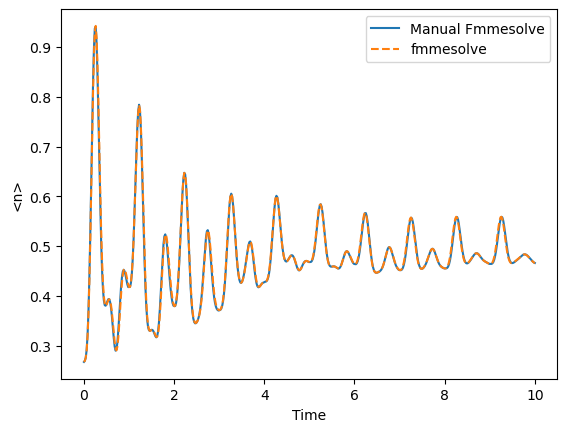

In [17]:
# Solve using Fmmesolve
fme_result = fmmesolve(
    H,
    psi0,
    tlist,
    c_ops=c_ops,
    spectra_cb=[noise_spectrum],
    e_ops=[num(2)],
    T=T,
    args=args,
    floquet_basis=False,
)

plt.plot(tlist, res_fme_manual.expect[0], label="Manual Fmmesolve")
plt.plot(tlist, fme_result.expect[0], "--", label="fmmesolve")
plt.xlabel("Time"), plt.ylabel("<n>"), plt.legend();

### About

In [18]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.1
Numpy Version:      1.22.4
Scipy Version:      1.8.1
Cython Version:     0.29.33
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     2
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/work/qutip-tutorials/qutip-tutorials/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily gene

## Testing

In [19]:
assert np.allclose(fme_result.expect[0], res_fme_manual.expect[0], atol=0.1)
assert np.std(fme_result.expect[0][0: tlist_period.shape[0]]) > np.std(
    fme_result.expect[0][-tlist_period.shape[0]: -1]
)
# compute prediction using sesolve
res_sesolve = sesolve(H, psi0, tlist, [num(2)])
assert np.allclose(res_sesolve.expect[0], p_ex, atol=0.15)